In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images.astype("float32") / 255.0).reshape(-1, 28, 28, 1)
test_images = (test_images.astype("float32") / 255.0).reshape(-1, 28, 28, 1)

print("Training images shape:", train_images.shape)  
print("Testing images shape:", test_images.shape)

Training images shape: (60000, 28, 28, 1)
Testing images shape: (10000, 28, 28, 1)


In [3]:
data_variance = np.var(train_images)
data_variance

0.09493039

In [4]:
# Parameters
embedding_dim = 16  # Dimensionality of the embedding space
num_embeddings = 128  # Number of embedding vectors
beta = 0.25  # Commitment loss factor

In [5]:
# VQ-VAE Encoder
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same')
        self.conv3 = layers.Conv2D(16, 1, strides=1, padding='same')

    def call(self, x):
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [6]:
# VQ-VAE Decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same')
        self.conv2 = layers.Conv2DTranspose(32, 3, strides=2, padding='same')
        self.conv3 = layers.Conv2DTranspose(1, 3, strides=1, padding='same')

    def call(self, x):
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [7]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        self.embeddings = self.add_weight(shape=(num_embeddings, embedding_dim), initializer='uniform', trainable=True)

    def call(self, x):
        flat_x = tf.reshape(x, [-1, self.embedding_dim])
        distances = (tf.reduce_sum(flat_x ** 2, axis=1, keepdims=True) 
                     - 2 * tf.matmul(flat_x, self.embeddings, transpose_b=True)
                     + tf.reduce_sum(self.embeddings ** 2, axis=1)) #-----------------------------> Try axis=0
        encoding_indices = tf.argmin(distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings)
        quantized = tf.reshape(quantized, tf.shape(x))

        # Loss for commitment to the codebook
        commitment_loss = self.beta * tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        #self.add_loss(commitment_loss)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized, encodings, encoding_indices

In [8]:
class VQVAE(Model):
    def __init__(self, embedding_dim, num_embeddings, beta):
        super(VQVAE, self).__init__()
        self.encoder = Encoder()
        self.vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder()

    def call(self, x):
        z_e = self.encoder(x)
        quantized, encodings, encoding_indices = self.vector_quantizer(z_e)
        x_recon = self.decoder(quantized)
        return x_recon, encodings, encoding_indices

In [9]:
vqvae = VQVAE(embedding_dim, num_embeddings, data_variance)
optimizer = tf.keras.optimizers.Adam()

2024-10-18 01:24:55.469527: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-10-18 01:24:55.469550: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-10-18 01:24:55.469555: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-10-18 01:24:55.469569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-18 01:24:55.469578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Prepare dataset
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(100).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

In [11]:
# Training VQ-VAE
def train_vqvae(dataset, epochs):
    for epoch in range(epochs):
        for step, x_batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                recon_images, _, _ = vqvae(x_batch)
                loss = tf.reduce_mean((x_batch - recon_images) ** 2) + sum(vqvae.losses)

            grads = tape.gradient(loss, vqvae.trainable_variables)
            optimizer.apply_gradients(zip(grads, vqvae.trainable_variables))

        print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

In [12]:
# Train VQ-VAE
train_vqvae(train_dataset, epochs=30)

2024-10-18 01:25:21.288589: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 10.040522575378418


2024-10-18 01:25:45.819036: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 3.3337974548339844
Epoch 3, Loss: 1.9869105815887451


2024-10-18 01:26:34.666901: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 1.2510075569152832
Epoch 5, Loss: 0.9554846882820129
Epoch 6, Loss: 0.7310454249382019
Epoch 7, Loss: 0.6489964723587036


2024-10-18 01:28:12.981603: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.5911243557929993
Epoch 9, Loss: 0.5745515823364258
Epoch 10, Loss: 0.5394605994224548
Epoch 11, Loss: 0.5059765577316284
Epoch 12, Loss: 0.5196399092674255
Epoch 13, Loss: 0.5128920674324036
Epoch 14, Loss: 0.4865480363368988
Epoch 15, Loss: 0.4954083561897278


2024-10-18 01:31:28.333449: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Loss: 0.48184138536453247
Epoch 17, Loss: 0.49398499727249146
Epoch 18, Loss: 0.47353866696357727
Epoch 19, Loss: 0.455230712890625
Epoch 20, Loss: 0.44411712884902954
Epoch 21, Loss: 0.45251891016960144
Epoch 22, Loss: 0.43774616718292236
Epoch 23, Loss: 0.43513134121894836
Epoch 24, Loss: 0.4364710748195648
Epoch 25, Loss: 0.42168742418289185
Epoch 26, Loss: 0.42008277773857117
Epoch 27, Loss: 0.4263644218444824
Epoch 28, Loss: 0.4121641516685486
Epoch 29, Loss: 0.39981770515441895
Epoch 30, Loss: 0.40170344710350037


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


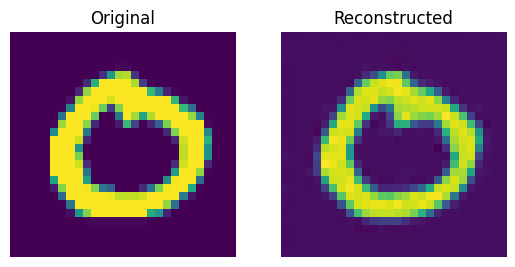

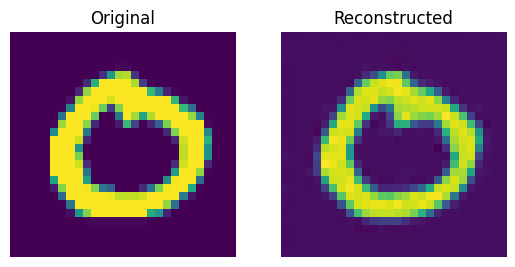

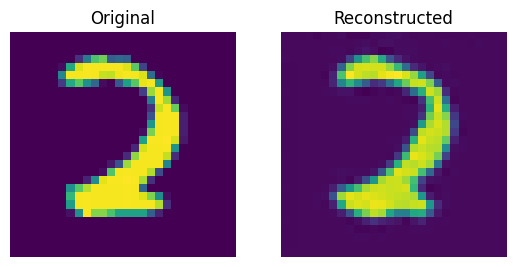

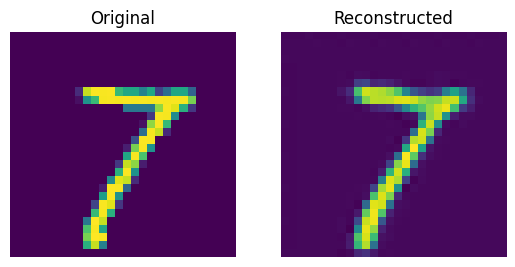

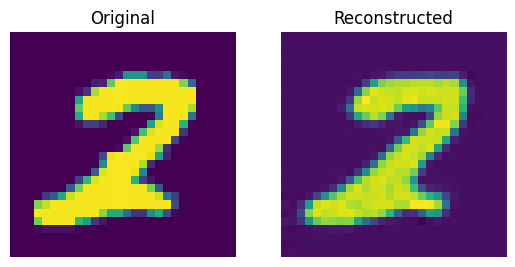

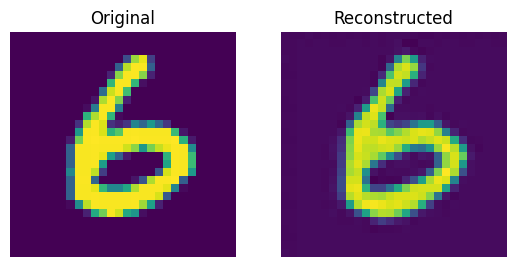

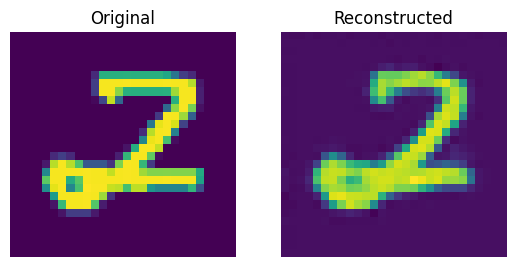

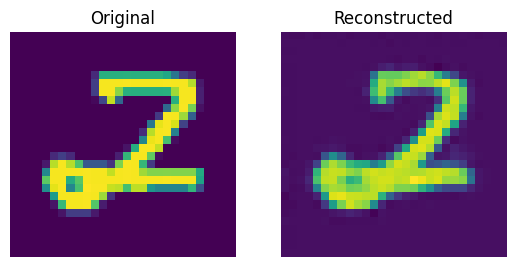

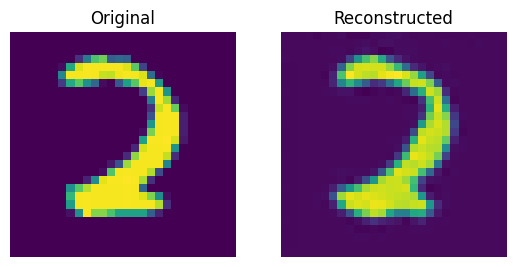

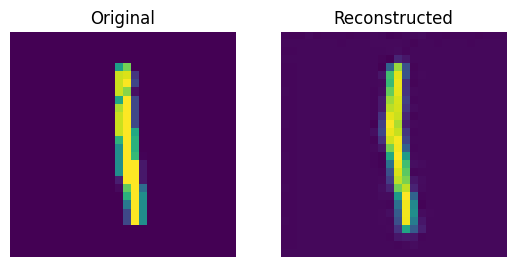

In [24]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


idx = np.random.choice(len(test_images), 10)
test_images = test_images[idx]
reconstructions_test = vqvae.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test[0]):
    show_subplot(test_image, reconstructed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


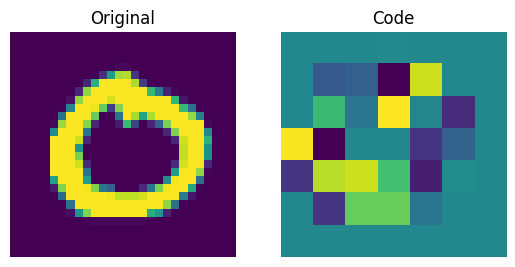

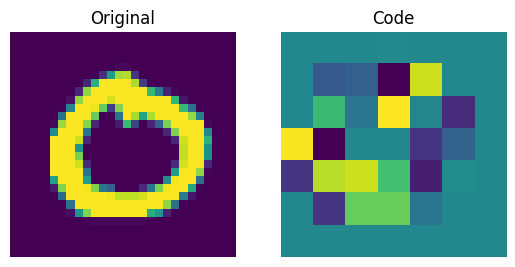

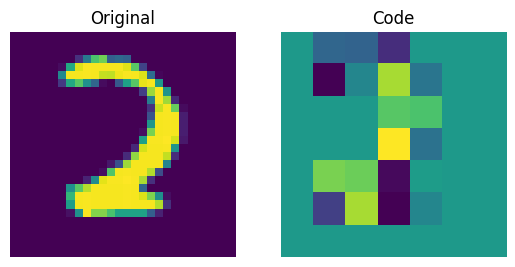

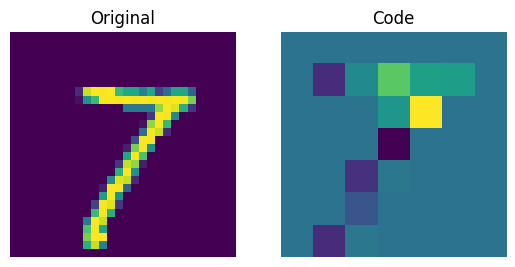

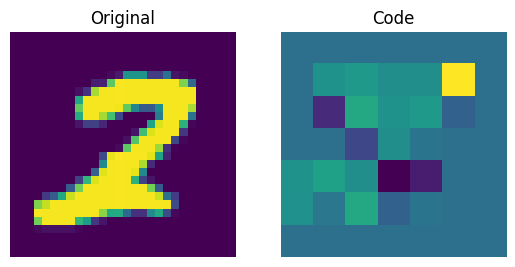

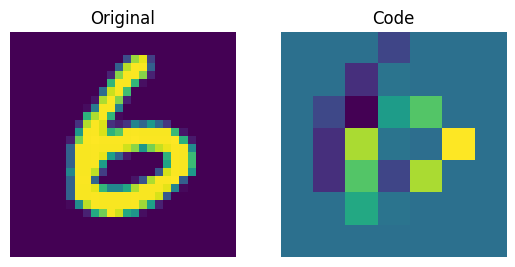

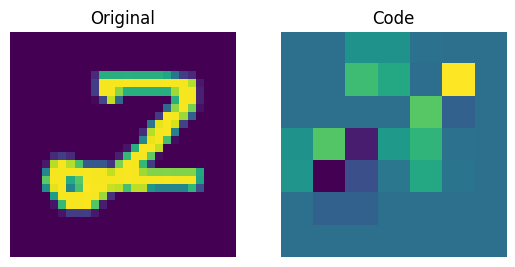

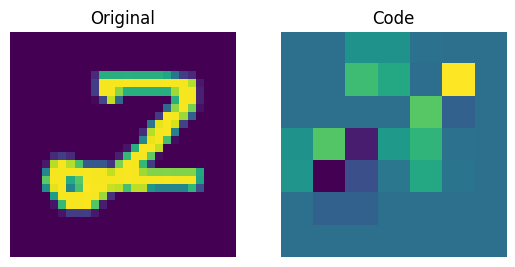

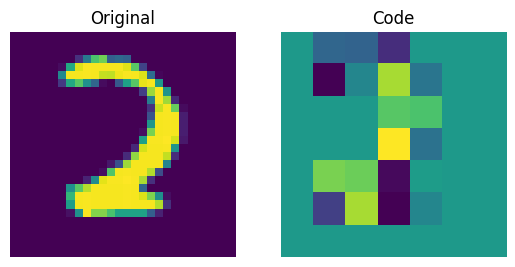

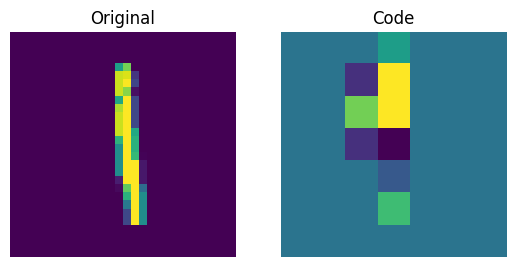

In [47]:
encoder = vqvae.encoder
quantizer = vqvae.vector_quantizer

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
_, _, codebook_indices = quantizer(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [106]:
def get_encoding_indices(model, dataset):
    encoding_indices = []
    for x_batch in dataset:
        _, _, batch_indices = model(x_batch)
        #encoding_indices.append(batch_indices.numpy())
        encoding_indices.append(batch_indices.numpy().reshape((-1, 7, 7)))
    return np.concatenate(encoding_indices, axis=0)

train_encoding_indices = get_encoding_indices(vqvae, train_dataset)
test_encoding_indices = get_encoding_indices(vqvae, test_dataset)

In [105]:
print("Training encoding indices shape:", train_encoding_indices.shape)  
print("Testing encoding indices shape:", test_encoding_indices.shape)

Training encoding indices shape: (60000, 7, 7)
Testing encoding indices shape: (10000, 7, 7)


In [73]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = (7, 7)
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


In [95]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [98]:
# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

In [102]:
class OneHotLayer(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, **kwargs):
        super(OneHotLayer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings

    def call(self, inputs):
        # One-hot encode the input tensor
        return tf.one_hot(inputs, self.num_embeddings)


pixelcnn_inputs = tf.keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
#ohe = tf.one_hot(pixelcnn_inputs, num_embeddings)
ohe = OneHotLayer(num_embeddings=num_embeddings)(pixelcnn_inputs)

x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = tf.keras.layers.Conv2D(
    filters=num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = tf.keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 7, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ one_hot_layer_5 (OneHotLayer)   │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_18             │ (None, 7, 7, 128)      │       802,944 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (None, 7, 7, 128)      │        98,624 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_8                │ (None, 7, 7, 128)      │        98,624 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_21             │ (None, 7, 7, 128)      │        16,512 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_conv_layer_22             │ (None, 7, 7, 128)      │        16,512 │
│ (PixelConvLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 7, 7, 128)      │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,049,728 (4.00 MB)

 Trainable params: 1,049,728 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
pixel_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [107]:
pixel_cnn.fit(
    x=train_encoding_indices,
    y=train_encoding_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.6391 - loss: 2.3769 - val_accuracy: 0.6906 - val_loss: 1.1399
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.6979 - loss: 1.0955 - val_accuracy: 0.7091 - val_loss: 1.0257
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7127 - loss: 1.0061 - val_accuracy: 0.7157 - val_loss: 0.9865
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7184 - loss: 0.9716 - val_accuracy: 0.7197 - val_loss: 0.9648
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7231 - loss: 0.9448 - val_accuracy: 0.7213 - val_loss: 0.9496
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7262 - loss: 0.9284 - val_accuracy: 0.7236 - val_loss: 0.9384
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7290 - loss: 0.9153 - val_accuracy: 0.7245 - val_loss: 0.9323
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7313 - loss: 0.9040 - 

In [121]:
import tensorflow_probability as tfp

class CategoricalDistributionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CategoricalDistributionLayer, self).__init__(**kwargs)

    def call(self, logits):
        # Create a categorical distribution from logits
        distribution = tfp.distributions.Categorical(logits=logits)
        # Sample from the distribution to get the output
        return distribution.sample()  # Ensure to return a tensor

    def get_config(self):
        config = super(CategoricalDistributionLayer, self).get_config()
        return config

iinputs = tf.keras.Input(shape=(None, 7, 7, 128))  # Adjust the shape as needed
outputs = pixel_cnn(inputs, training=False)

# Use the categorical distribution layer
categorical_layer = CategoricalDistributionLayer()
outputs = categorical_layer(outputs)

# Create the model
sampler = tf.keras.Model(inputs, outputs)
sampler.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 7, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_cnn (Functional)          │ (None, 7, 7, 128)      │     1,049,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ categorical_distribution_layer… │ (None, 7, 7)           │             0 │
│ (CategoricalDistributionLayer)  │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,049,728 (4.00 MB)

 Trainable params: 1,049,728 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


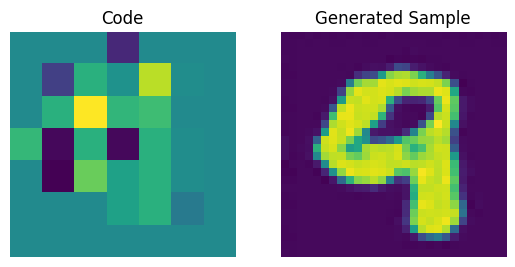

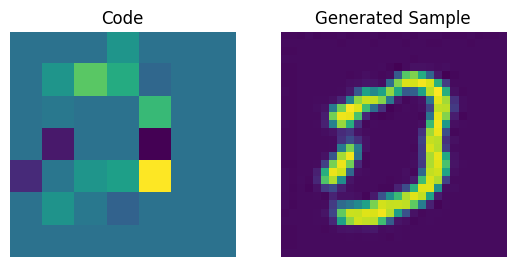

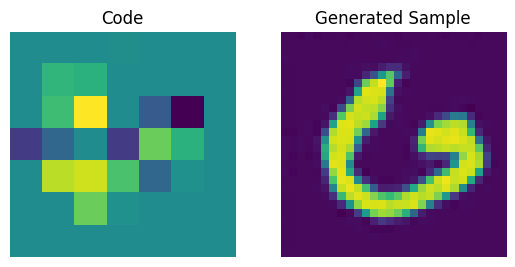

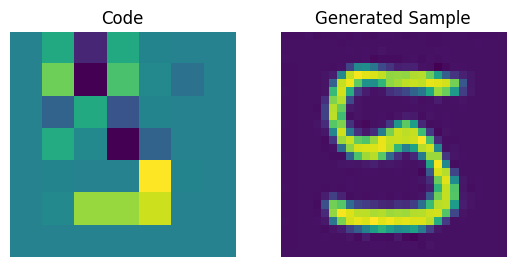

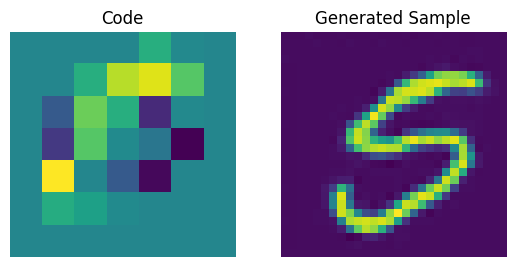

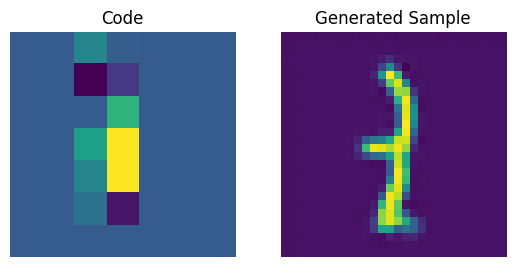

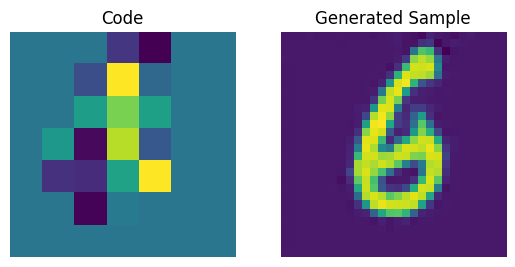

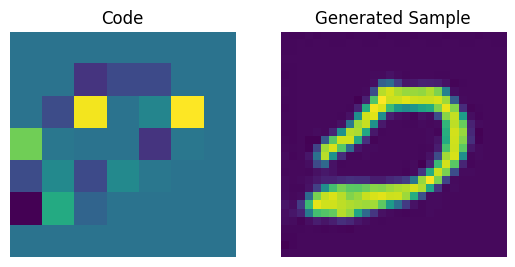

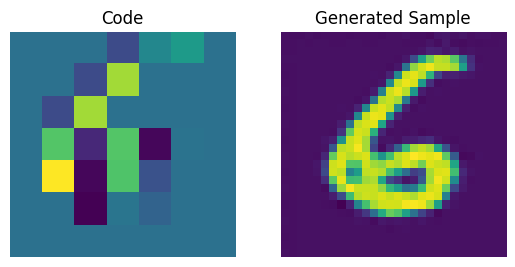

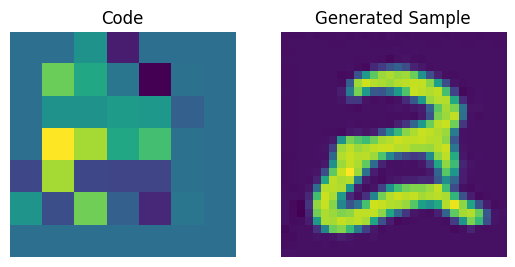

In [132]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), num_embeddings).numpy()
priors_ohe_reshaped = tf.reshape(priors_ohe, (-1, 128))
quantized = tf.matmul(priors_ohe_reshaped, pretrained_embeddings) 
#quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))
quantized = tf.reshape(quantized, (-1, 7, 7, 16)) 

# Generate novel images.
decoder = vqvae.decoder
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()